# When you need an awkward array

This is a sample script that uses the ad-hoc analysis library to events from an xAOD.

- Run Number
- Event Number
- Jet Eta's for the event
- Jet pt's for the event
- All tracks.

The jets must have $p_T > 40$ GeV, and the tracks must have $p_T > 1$ GeV.

In particular this means that the different columns have different lengths. A `pandas.DataFrame` is not suitable as a return type. Instead, we will use an `awkward` array.

## Setup and Config

In [1]:
fname = r"file://G:/mc16_13TeV/AOD.16300985._000011.pool.root.1"

In [2]:
%%time
import sys
sys.path.append('..')
from clientlib.DataSets import EventDataSet
from cpplib.math_utils import DeltaR

Wall time: 706 ms


## Import the events into a Pandas array.

First thing we do is turn a dataset into an implicit stream of events.

In [3]:
%%time
f = EventDataSet(fname)
events = f.AsATLASEvents()

Wall time: 0 ns


We will get the stream of jets in several steps. We could do this in one step, but it is easier to read.

We now also include the `tracks` collection. Note that we apply a `Where` filter to it so that only those tracks that have a large enough pt survive our collection. This means the `event_info` tuple now contains, for each event:

- The `EventInfo` object (run number, etc.)
- A list of all jets wiht $p_T > 40$ GeV
- A list of all tracks with $p_T > 1$ GeV.

In [4]:
%%time
event_info = events \
            .Select("lambda e: (e.EventInfo('EventInfo'), e.Jets('AntiKt4EMTopoJets').Where(lambda j: j.pt()/1000.0 > 40.0), e.Tracks('InDetTrackParticles').Where(lambda t: t.pt() > 1000.0))")

Wall time: 0 ns


The `event_info` iterator is a sequence of events - one per event. Next we define the columns we want to see in our awkward array.

In [5]:
event_data = event_info \
            .Select('lambda j1: (j1[0].runNumber(), j1[0].eventNumber(), j1[1].Select(lambda j2: j2.pt()/1000.0), j1[1].Select(lambda j3: j3.eta()), j1[2].Select(lambda t2: t2.pt()/1000.0))')

And finally turn it into a awkward array. Each row has information associated with a single event.

At this point no execution happens - a "future" is now setup which will return the awkward array when evaluated.

Note we can return several datatypes that might be suitable:

- A Pandas DataFrame (this won't work for this example as each column is not the same length)
- An awkward array
- A ROOT file with a TTree. A tuple is returned in this case with the filename and the name of the tree in the file - the user may open it as they wish.

In [6]:
%%time
training_df = event_data.AsAwkwardArray(columns=['Run', 'Event', 'JetPt', 'JetEta', 'TrackPt'])

Wall time: 0 ns


Finally, we turn it into something real. The following steps occur:

1. Some C++ code is written to access, read the xAOD jet's, create a ttree, and write it out.
1. A docker container with the ATLAS envrionment is started. The code and the data file location are mapped into it.
1. The code is compiled, and then run.
1. The output ROOT file is loaded with uproot and a DF is created.
1. All that temporary code and data is removed.

There is a fair amount of log file information that appears in the notebook engine window. At the moement that is not correctly redirected here - so you can see evidence of it running there.

In [7]:
%%time
df = training_df.value()

Process result is  0
Wall time: 31.6 s


## The Dataframe

Now we can play with the dataframe as we wish.

In [8]:
df

{b'Run': array([300000., 300000., 300000., ..., 300000., 300000., 300000.],
       dtype=float32),
 b'Event': array([16000310., 16000256., 16002559., ..., 16003589., 16000303.,
        16002703.], dtype=float32),
 b'JetPt': <JaggedArray [[257.3164367675781 253.13232421875 47.16945266723633] [386.493408203125 339.7240295410156] [205.48191833496094 145.9190216064453] ... [270.0296936035156 235.0580596923828] [295.9820861816406 239.0131378173828 137.13156127929688 58.33217239379883 42.6482048034668] [373.2308654785156 197.72581481933594 176.5972900390625 153.0657958984375]] at 0x024ec9523f98>,
 b'JetEta': <JaggedArray [[1.4384255409240723 0.6565013527870178 -2.6482956409454346] [2.0734965801239014 -0.08200427144765854] [-1.1604390144348145 1.1042412519454956] ... [-0.8287546038627625 -1.3372952938079834] [0.04100418463349342 0.5062792897224426 0.2755782902240753 -2.539562463760376 0.1658107340335846] [1.0028400421142578 -0.9127013087272644 -0.1290564388036728 1.9479498863220215]] at 0x024

In [9]:
%%time
import matplotlib.pyplot as plt

Wall time: 213 ms


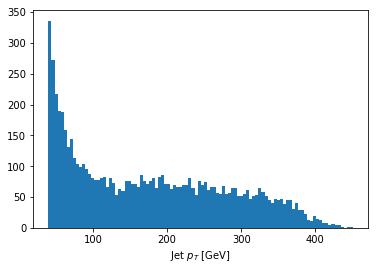

In [10]:
_ = plt.hist(df[b'JetPt'].content, bins=100)
_ = plt.xlabel("Jet $p_T$ [GeV]")

Note the cut off at 40 GeV on the low end.

Wall time: 93 ms


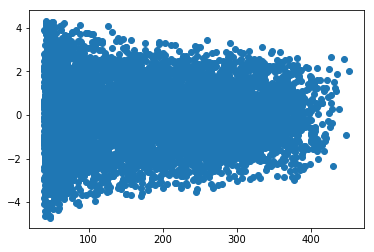

In [11]:
%%time
_ = plt.scatter(df[b'JetPt'].content, df[b'JetEta'].content)

As expected we can see the higher pt jets tend to be more central

We can also look at the number of tracks as a function of jet $p_T$.

Wall time: 122 ms


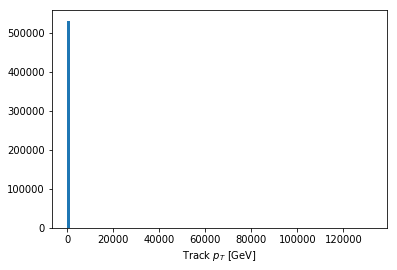

In [12]:
%%time
_ = plt.hist(df[b'TrackPt'].content, bins=100)
_ = plt.xlabel('Track $p_T$ [GeV]')

## Limitations

This is demo code. There are a number of limitations:

- Only Jets, Tracks, and EventInfo is understood (easy to add new C++ collections or objects). You can alter the name of the collection you want to access.
- Basic operations are possible, like jet.pt()/1000.0. But no effor had been made to have a complete set of operations yet.
- Only a single query at a time is possible. However you can create multiple columns in the dataframe (with jet pt and eta, for example).
- Obviously, tuples quickly become unweildy. Named tuples would be the obvious thing to use - and there is no techincal reason not to use them. Eventually.